In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pypokerengine.players import BasePokerPlayer
from pypokerengine.utils.card_utils import Card, Deck
# from pypokerengine.utils.game_state_utils import restore_game_state
from pypokerengine.api.game import setup_config, start_poker
# from pypokerengine.api.emulator import Emulator, ActionChecker, RoundManager,MessageBuilder, Const, Event,\
#                                        DataEncoder
import pickle
import tensorflow as tf
import random

import sys
sys.path.insert(0, '../scripts/')

import PlayerModels as pm
from MyEmulator import MyEmulator
from DQNPlayer import DQNPlayer
from util import *

### Graph

In [2]:
def update_target_graph(tf_vars, tau):
    total_vars = len(tf_vars)
    ops = []
    for i, var in enumerate(tf_vars[0:total_vars // 2]):
        ops.append(tf_vars[i + total_vars // 2].assign((var.value() * tau) +
                                                       (tf_vars[i + total_vars // 2].value() * (1 - tau))))
    return ops

def update_target(ops, sess):
    for op in ops:
        sess.run(op)

## Training

In [3]:
batch_size = 128
update_freq = 50 # how often to update model
y = 0.99 # discount
start_E = 1 # starting chance of random action
end_E = 0.2 # final chance of random action
annealings_steps = 100_000 # how many steps to reduce start_E to end_E
num_episodes = 500_000
pre_train_steps = 5_000 # how many steps of random action before training begin
load_model = False
path = '../cache/models/DQN/'
h_size = 128 # the size of final conv layer before spliting it into advantage and value streams
tau = 0.01 # rate to update target network toward primary network
is_dueling = True # whether or not to use dueling architecture

In [4]:
emul = MyEmulator()
emul.set_game_rule(9, 50, 15, 0)
my_uuid = '1'
players_info = {
    "1": { "name": "f1", "stack": 1500 },
    "2": { "name": "f2", "stack": 1500 },
    "3": { "name": "f3", "stack": 1500 },
    "4": { "name": "f4", "stack": 1500 },
    "5": { "name": "f5", "stack": 1500 },
    "6": { "name": "f6", "stack": 1500 },
    "7": { "name": "f7", "stack": 1500 },
    "8": { "name": "f8", "stack": 1500 },
    "9": { "name": "f9", "stack": 1500 }
}

In [5]:
def init_emul(my_uuid_):
    global my_uuid
    my_uuid = my_uuid_
    
#     emul.register_player("1", pm.CallPlayer())
#     emul.register_player("2", pm.CallPlayer())
#     emul.register_player("3", pm.CallPlayer())
#     emul.register_player("4", pm.CallPlayer())
#     emul.register_player("5", pm.CallPlayer())
#     emul.register_player("6", pm.CallPlayer())
#     emul.register_player("7", pm.CallPlayer())
#     emul.register_player("8", pm.CallPlayer())
#     emul.register_player("9", pm.CallPlayer())
    
    emul.register_player("1", pm.CallPlayer())
    emul.register_player("2", pm.CallPlayer())
    emul.register_player("3", pm.FoldPlayer())
    emul.register_player("4", pm.FoldPlayer())
    emul.register_player("5", pm.HeuristicPlayer())
    emul.register_player("6", pm.HeuristicPlayer())
    emul.register_player("7", pm.RandomPlayer())
    emul.register_player("8", pm.RandomPlayer())
    emul.register_player("9", pm.CallPlayer())


    players_info = {
        "1": { "name": "CallPlayer1", "stack": 1500 },
        "2": { "name": "CallPlayer2", "stack": 1500 },
        "3": { "name": "FoldPlayer1", "stack": 1500 },
        "4": { "name": "FoldPlayer2", "stack": 1500 },
        "5": { "name": "HeuristicPlayer1", "stack": 1500 },
        "6": { "name": "HeuristicPlayer2", "stack": 1500 },
        "7": { "name": "RandomPlayer1", "stack": 1500 },
        "8": { "name": "RandomPlayer2", "stack": 1500 },
        "9": { "name": "DQN", "stack": 1500 }
    }

In [6]:
tf.reset_default_graph()
main_wp = DQNPlayer(h_size, is_double=True)
target_wp = DQNPlayer(h_size, is_main=False, is_double=True)

### Overfit on small

#### Before you need to call cell below at least for 1 minute

In [7]:
# %%time
# init = tf.global_variables_initializer()
# trainables = tf.trainable_variables()
# target_ops = update_target_graph(trainables, tau)

# with tf.Session() as sess:
#     sess.run(init)
#     if load_model:
#         print('Loading model')
#         ckpt = tf.train.get_checkpoint_state(path)
#         saver.restore(sess, ckpt.model_checkpoint_path)
#     train_batch = my_buffer.sample(batch_size)
#     for i in range(num_episodes):      
#         Q1 = sess.run(main_wp.predict,
#                       feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
#                                  main_wp.features_input: np.vstack(train_batch[:, 5])})
#         Q1_ = sess.run(main_wp.Q_out,
#                       feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
#                                  main_wp.features_input: np.vstack(train_batch[:, 5])})

#         Q2 = sess.run(target_wp.Q_out,
#                       feed_dict={target_wp.scalar_input: np.vstack(train_batch[:, 4]),
#                                  target_wp.features_input: np.vstack(train_batch[:, 5])})
#         end_multiplier = -(train_batch[:, 6] - 1)
#         double_Q = Q2[range(batch_size), Q1]
#         double_Q_ = Q1_[range(batch_size), Q1]

#         target_Q = train_batch[:, 3] + (y * double_Q * end_multiplier)

#         _, er, g, v = sess.run([main_wp.update_model,
#                           main_wp.loss, main_wp.grad_norms, main_wp.var_norms],
#                      feed_dict={
#                          main_wp.scalar_input: np.vstack(train_batch[:, 0]),
#                          main_wp.features_input: np.vstack(train_batch[:, 1]),
#                          main_wp.target_Q: target_Q,
#                          main_wp.actions: train_batch[:, 2]
#                      })
#         update_target(target_ops, sess)
        
#         q1 = double_Q_[0]
#         q2 = double_Q[0]

#         summary = tf.Summary()
#         summary.value.add(tag='Q/Q1', simple_value=float(q1))
#         summary.value.add(tag='Q/Q2', simple_value=float(q2))
#         summary.value.add(tag='Q/Target', simple_value=target_Q[0])
#         summary.value.add(tag='Q/Action', simple_value=Q1[0])
#         summary.value.add(tag='Loss/Error', simple_value=er)
#         summary.value.add(tag='Loss/Grad_norm', simple_value=g)
#         summary.value.add(tag='Loss/Var_norm', simple_value=v)

#         main_wp.summary_writer.add_summary(summary, i)
#         if i % 2 == 0:
#             main_wp.summary_writer.flush()
                            
#         if i % 100 == 0:
#             print(i, total_steps, np.mean(r_list[-10:]), e, np.median(action_list[-200:]))            
# print('Mean reward: {}'.format(sum(r_list) / num_episodes))

## Training at all

In [ ]:
%%time
init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=3)
trainables = tf.trainable_variables()
target_ops = update_target_graph(trainables, tau)
my_buffer = ExperienceBuffer()

e = start_E
step_drop = (start_E - end_E) / annealings_steps

j_list = []
r_list = []
action_list = []
total_steps = 0

with tf.Session() as sess:
    sess.run(init)
    if load_model:
        print('Loading model')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episode_buffer = ExperienceBuffer()
        init_emul(str(np.random.randint(1, 10)))
        
        initial_state = emul.generate_initial_game_state(players_info)
        msgs = []
        game_state, events = emul.start_new_round(initial_state)
        is_last_round = False
        r_all = 0
        j = 0
        
        last_img_state = None
        last_features = None
        last_action_num = None
        
        while not is_last_round:
            j += 1
            a = emul.run_until_my_next_action(game_state, my_uuid, msgs)
            
            # need to make move
            if len(a) == 4:
                game_state, valid_actions, hole_card, round_state = a
                img_state = img_from_state(hole_card, round_state)
                img_state = process_img(img_state)
                
                street = round_state['street']
                bank = round_state['pot']['main']['amount']
                stack = [s['stack'] for s in round_state['seats'] if s['uuid'] == my_uuid][0]
                other_stacks = [s['stack'] for s in round_state['seats'] if s['uuid'] != my_uuid]
                dealer_btn = round_state['dealer_btn']
                small_blind_pos = round_state['small_blind_pos']
                big_blind_pos = round_state['big_blind_pos']
                next_player = round_state['next_player']
                round_count = round_state['round_count']
                estimation = main_wp.hole_card_est[(hole_card[0], hole_card[1])]


                features = get_street(street)
                features.extend([bank, stack, dealer_btn, small_blind_pos, big_blind_pos, next_player, round_count])
                features.extend(other_stacks)
                features.append(estimation)
        
                
                # add to buffer last hand 
                if last_img_state is not None:
                    episode_buffer.add(np.reshape(np.array([last_img_state, last_features, last_action_num,
                                                            0, img_state, features, 0]), [1, 7]))
                
                if np.random.rand(1) < e or total_steps < pre_train_steps:
                    action_num = np.random.randint(0, main_wp.total_num_actions)
                else:
                    action_num = sess.run(main_wp.predict, feed_dict={main_wp.scalar_input: [img_state],
                                                                      main_wp.features_input: [features]})[0]
                    
                action_list.append(action_num)
                action, amount = get_action_by_num(action_num, valid_actions)                    

                game_state, msgs = emul.apply_my_action(game_state, action, amount)
                total_steps += 1
        
                last_img_state = img_state.copy()
                last_features = features.copy()
                last_action_num = action_num
                
                if total_steps > pre_train_steps:
                    if e > end_E:
                        e -= step_drop
                    
                    if total_steps % (update_freq) == 0:
                        train_batch = my_buffer.sample(batch_size)

                        Q1 = sess.run(main_wp.predict,
                                      feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                                 main_wp.features_input: np.vstack(train_batch[:, 5])})
                        Q1_ = sess.run(main_wp.Q_out,
                                      feed_dict={main_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                                 main_wp.features_input: np.vstack(train_batch[:, 5])})
        
                        Q2 = sess.run(target_wp.Q_out,
                                      feed_dict={target_wp.scalar_input: np.vstack(train_batch[:, 4]),
                                                 target_wp.features_input: np.vstack(train_batch[:, 5])})
                        end_multiplier = -(train_batch[:, 6] - 1)
                        double_Q = Q2[range(batch_size), Q1]
                        double_Q_ = Q1_[range(batch_size), Q1]
                        
                        if is_dueling:
                            target_Q = train_batch[:, 3] + (y * double_Q * end_multiplier)
                        else:
                            target_Q = train_batch[:, 3] + (y * double_Q_ * end_multiplier)

                        _, er, g, v = sess.run([main_wp.update_model,
                                          main_wp.loss, main_wp.grad_norms, main_wp.var_norms],
                                     feed_dict={
                                         main_wp.scalar_input: np.vstack(train_batch[:, 0]),
                                         main_wp.features_input: np.vstack(train_batch[:, 1]),
                                         main_wp.target_Q: target_Q,
                                         main_wp.actions: train_batch[:, 2]
                                     })
                        update_target(target_ops, sess)
                        
                        r = np.mean(r_list[-2:])
                        j = np.mean(j_list[-2:])
                        q1 = double_Q_[0]
                        q2 = double_Q[0]
                        al = np.mean(action_list[-10:])
                                                
                        summary = tf.Summary()
                        summary.value.add(tag='Perf/Reward', simple_value=float(r))
                        summary.value.add(tag='Perf/Lenght', simple_value=float(j))
                        summary.value.add(tag='Perf/Action_list', simple_value=al)
                        summary.value.add(tag='Perf/E', simple_value=e)                        
                        summary.value.add(tag='Q/Q1', simple_value=float(q1))
                        summary.value.add(tag='Q/Q2', simple_value=float(q2))
                        summary.value.add(tag='Q/Target', simple_value=target_Q[0])
                        summary.value.add(tag='Q/Action', simple_value=Q1[0])
                        summary.value.add(tag='Loss/Error', simple_value=er)
                        summary.value.add(tag='Loss/Grad_norm', simple_value=g)
                        summary.value.add(tag='Loss/Var_norm', simple_value=v)
                        
                        main_wp.summary_writer.add_summary(summary, total_steps)
                        if total_steps % (update_freq * 2) == 0:
                            main_wp.summary_writer.flush()
                        
#                         tf.summary.histogram('Q1', Q1_)
#                         tf.summary.histogram('Q2', Q2)
            else:
                game_state, reward = a
                if reward >= 0:
                    reward = np.log(1 + reward)
                else:
                    reward = -np.log(1 - reward)
                r_all += reward
                # add to buffer last hand 
                if last_img_state is not None:
                    episode_buffer.add(np.reshape(np.array([last_img_state, last_features, last_action_num,
                                                            reward, last_img_state, last_features, 1]), [1, 7]))
                
                is_last_round = emul._is_last_round(game_state, emul.game_rule)
                game_state, events = emul.start_new_round(game_state)

                last_img_state = None
                last_action_num = None   
            
        my_buffer.add(episode_buffer.buffer)
        r_list.append(r_all)
        j_list.append(j)

        if i % 1000 == 0:
#             saver.save(sess, path + '/model_' + str(i) + '.ckpt')
            saver.save(sess, path, i)

            print('Saved model')
        if i % 100 == 0:
            print(i, total_steps, np.mean(r_list[-10:]), e, np.median(action_list[-200:]))            
    saver.save(sess, path + '/model_' + str(i) + '.ckpt')
print('Mean reward: {}'.format(sum(r_list) / num_episodes))

Saved model
0 5 -7.31388683163 1 2.0


To see the training progress type in console:
tensorboard --logdir=log/DQN/

## Model analysis

In [24]:
vars_ = tf.trainable_variables()[:len(tf.trainable_variables()) // 2]

In [25]:
total_parameters = 0
for variable in vars_:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    print(shape)
    print(len(shape))
    variable_parameters = 1
    for dim in shape:
        print(dim)
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

(5, 5, 1, 32)
4
5
5
1
32
800
(32,)
1
32
32
(3, 3, 32, 64)
4
3
3
32
64
18432
(64,)
1
64
64
(5, 5, 64, 128)
4
5
5
64
128
204800
(128,)
1
128
128
(20, 64)
2
20
64
1280
(64,)
1
64
64
(64, 128)
2
64
128
8192
(128,)
1
128
128
(256, 256)
2
256
256
65536
(256,)
1
256
256
(256, 128)
2
256
128
32768
(128,)
1
128
128
(128, 5)
2
128
5
640
(5,)
1
5
5
333253


### Time of one pass

In [31]:
import pandas as pd
%matplotlib inline

In [64]:
%time
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    print(ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    action_num = sess.run(main_wp.predict, feed_dict={main_wp.scalar_input: [train_batch[3][0]],
                                                      main_wp.features_input: [train_batch[3][1]]})[0]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs
../cache/models/DQN/-23000
INFO:tensorflow:Restoring parameters from ../cache/models/DQN/-23000


In [65]:
train_batch = my_buffer.sample(batch_size)

../cache/models/DQN/-23000
INFO:tensorflow:Restoring parameters from ../cache/models/DQN/-23000
CPU times: user 1min 19s, sys: 4.84 s, total: 1min 23s
Wall time: 49.3 s


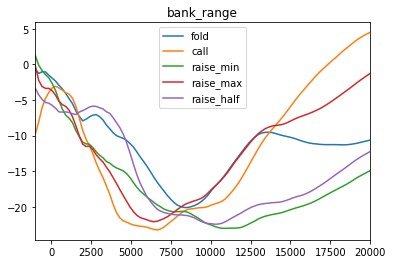

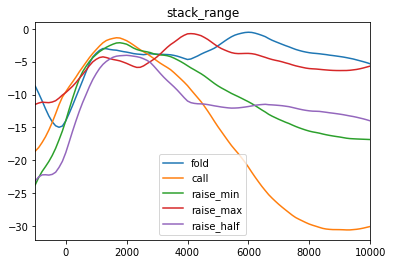

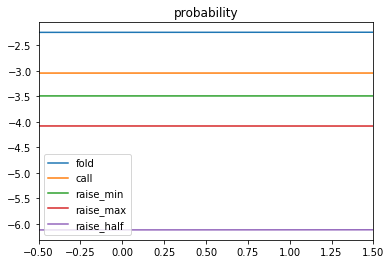

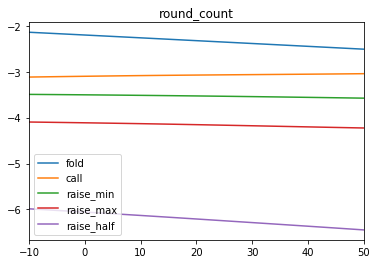

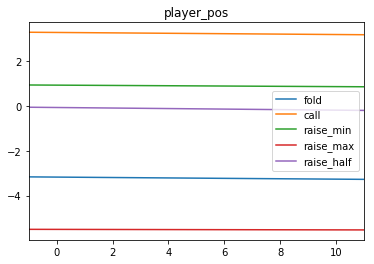

In [66]:
%%time
with tf.Session() as sess:
    qs1 = []
    qs2 = []
    qs3 = []
    qs4 = []
    qs5 = []

    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    print(ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path) # 'models/model_197000.ckpt')
    
    bank_range = np.linspace(-1000, 20000, 100)
    stack_range = np.linspace(-1000, 10000, 100)
    probability_range = np.linspace(-0.5, 1.5, 100)
    round_count_range = np.linspace(-10, 50, 100)
    player_pos_range = np.linspace(-1, 11, 100)

    for b in range(len(train_batch)):
        batch = train_batch[b]
        img = batch[0]
        features = batch[1]
        
        q1 = []
        q2 = []
        q3 = []
        q4 = []
        q5 = []
        
        for i in range(100):
            features = batch[1].copy()
            features[4] = bank_range[i]
            action_num = sess.run(main_wp.Q_out, feed_dict={main_wp.scalar_input: [img],
                                                          main_wp.features_input: [features]})[0]
            q1.append(action_num)

            features = batch[1].copy()
            features[5] = stack_range[i]
            action_num = sess.run(main_wp.Q_out, feed_dict={main_wp.scalar_input: [img],
                                                          main_wp.features_input: [features]})[0]
            q2.append(action_num)

            features = batch[1].copy()
            features[-1] = probability_range[i]
            action_num = sess.run(main_wp.Q_out, feed_dict={main_wp.scalar_input: [img],
                                                          main_wp.features_input: [features]})[0]
            q3.append(action_num)

            features = batch[1].copy()
            features[-10] = round_count_range[i]
            action_num = sess.run(main_wp.Q_out, feed_dict={main_wp.scalar_input: [img],
                                                          main_wp.features_input: [features]})[0]
            q4.append(action_num)
            
            features = batch[1].copy()
            features[-9] = player_pos_range[i]
            action_num = sess.run(main_wp.Q_out, feed_dict={main_wp.scalar_input: [img],
                                                          main_wp.features_input: [features]})[0]
            q5.append(action_num)
        
        if b == 0:
            qs1 = np.array(q1)
            qs2 = np.array(q2)
            qs3 = np.array(q3)
            qs4 = np.array(q4)
            qs5 = np.array(q5)
        else:
            qs1 += np.array(q1)
            qs2 += np.array(q2)
            qs3 += np.array(q3)
            qs4 += np.array(q4) 
            qs5 += np.array(q5) 

    qs1 /= len(train_batch)
    qs2 /= len(train_batch)
    qs3 /= len(train_batch)
    qs4 /= len(train_batch)      
    qs5 /= len(train_batch)      

    df1 = pd.DataFrame(qs1, columns=['fold', 'call', 'raise_min', 'raise_max', 'raise_half'])
    df1.plot(bank_range, ['fold', 'call', 'raise_min', 'raise_max', 'raise_half'], title='bank_range')

    df2 = pd.DataFrame(qs2, columns=['fold', 'call', 'raise_min', 'raise_max', 'raise_half'])
    df2.plot(stack_range, ['fold', 'call', 'raise_min', 'raise_max', 'raise_half'], title='stack_range')

    df3 = pd.DataFrame(qs3, columns=['fold', 'call', 'raise_min', 'raise_max', 'raise_half'])
    df3.plot(probability_range, ['fold', 'call', 'raise_min', 'raise_max', 'raise_half'], title='probability')
    
    df4 = pd.DataFrame(qs4, columns=['fold', 'call', 'raise_min', 'raise_max', 'raise_half'])
    df4.plot(round_count_range, ['fold', 'call', 'raise_min', 'raise_max', 'raise_half'], title='round_count')
    
    df5 = pd.DataFrame(qs5, columns=['fold', 'call', 'raise_min', 'raise_max', 'raise_half'])
    df5.plot(player_pos_range, ['fold', 'call', 'raise_min', 'raise_max', 'raise_half'], title='player_pos')

### Features

In [34]:
features

[0,
 0,
 0,
 1,
 20000.0,
 1410,
 0,
 1,
 2,
 7,
 1,
 1410,
 1410,
 1410,
 1410,
 1410,
 1410,
 1410,
 1410,
 0.0569]

### Hist with probability win in batch

In [55]:
pr = [t[1][-1] for t in train_batch]

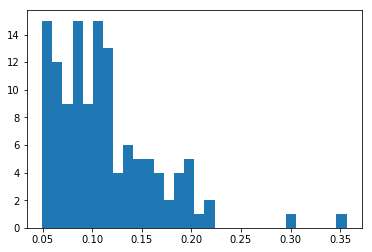

In [57]:
plt.hist(pr, bins=30);

In [69]:
pr = [t[1][10] for t in train_batch]

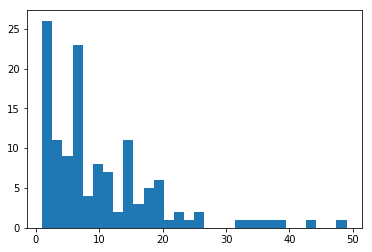

In [70]:
plt.hist(pr, bins=30);

### Weights of the network

In [35]:
kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2d/kernel')
d = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dense/kernel')

In [37]:
k = kernel[0]
d = d[0]

In [38]:
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess, ckpt.model_checkpoint_path)
    c1 = k.eval(session=sess)
    d1 = d.eval(session=sess)    

INFO:tensorflow:Restoring parameters from ../cache/models/DQN/-44000


In [39]:
c1.shape, d1.shape

((5, 5, 1, 32), (20, 64))

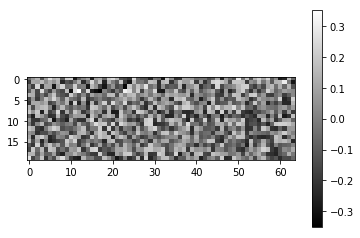

In [40]:
plt.imshow(d1)
plt.gray()
plt.colorbar()

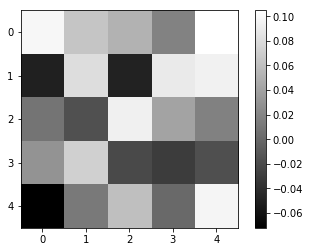

In [44]:
plt.imshow(c1[:, :, 0, 4])
plt.gray()
plt.colorbar()